# Van Krevelen Diagram Analysis Notebook

This notebook was originally for an incipient analysis of the discrimination of samples based on different multivariate analysis methods using the construction of a Van Krevelen diagram or the counts of composition series.

It was also used for the example Van Krevelen Diagrams and Kendrick Mass Defect plots - Fig. 1.4. of the dissertation.

For better explanation of the multivariate analysis, see BinSim_Analysis_GD11_all2_groups2all1.ipynb, since the 4 methods used are all applied according to the same rationale.

## Organization of the Notebook

- Imports and Presentation of the Notebook
- Reading the file (variant of the Yeast Dataset)
- Functions developed and needed for the preparation of the Van Krevelen Diagrams and application on a simple example
- Plotting different representations of Van Krevelen Diagrams and Kendrick Mass Defect Plots (Fig. for dissertation)
- Obtaining data for the Van krevelen Diagram and counts of number of elements in each composition series, treatments of this data to obtain 3 different datasets and Agglomerative Hierarchical Clustering (no evaluation metrics used for this one) and K-means Clustering
- Random Forest - predictive accuracy, important features and Permutation Tests
- PLS-DA - predictive accuracy, important features and Permutation Tests

Form point 5) onwards, comments and explanations are not very plentiful

### Notebook with Dissertation Figures - Fig. 1.4 (Introduction)

### Needed Imports

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import cm

import seaborn as sns
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats
import sklearn.cluster as skclust

import metabolinks as mtl

import scaling as sca
import multianalysis as ma

C:\Users\francisco\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
%matplotlib inline
from matplotlib import pyplot as pl

# Testing Files and Functions


In [3]:
# Function to remove features that appear in less the minsample fraction of the samples.
# keep_at_least function from metabolinks.transformations has the same idea, but here the spectra is transposed.
def remove_feat(Spectra, minsample=0):
    "Remove features that appear in less t"
    Imputated = Spectra
    df = Imputated
    if minsample != 0:
        NumValues = Imputated.iloc[:,3:].notnull()
        a = 0
        print(Spectra)
        for i in range(0, len(NumValues)): 
            if sum(NumValues.iloc[i, :]) < minsample*15:
                # Taking away features that appear in less of minsample fraction of samples.
                df = df.drop([df.iloc[a].name])
            else:
                a = a + 1

    return df

'ThesisSupportExcel.xlsx' is a file with a slightly different alignment and Formula Assignment of the Yeast Dataset used for the dissertation

In [4]:
# Reading the file, remove features 
by1_df_T = pd.read_excel('ThesisSupportExcel.xlsx', sheet_name='MS').set_index('Bucket label')
by1_df_T = by1_df_T.replace({0:np.nan})
#by1_df_T = remove_feat(by1_df_T, 2/15)
by1_df_T.info()
#by1_df_T
by1_df = by1_df_T.iloc[:,:4]
by1_df

<class 'pandas.core.frame.DataFrame'>
Index: 21328 entries, 307,0838178877 Da to 1941,3559575318 Da
Data columns (total 18 columns):
m/z             21328 non-null float64
Name            635 non-null object
Formula         17948 non-null object
BY0_000001      1949 non-null float64
BY0_000002      1953 non-null float64
BY0_000003      1954 non-null float64
GRE3_000001     1990 non-null float64
GRE3_000002     1960 non-null float64
GRE3_000003     1948 non-null float64
ENO1_000001     2057 non-null float64
ENO1_000002     2009 non-null float64
ENO1_000003     1998 non-null float64
dGLO1_000001    1978 non-null float64
dGLO1_000002    1932 non-null float64
dGLO1_000003    1950 non-null float64
GLO2_000001     1987 non-null float64
GLO2_000002     1952 non-null float64
GLO2_000003     1925 non-null float64
dtypes: float64(16), object(2)
memory usage: 3.1+ MB


,m/z,Name,Formula,BY0_000001
Bucket label,,,,
"307,0838178877 Da",308.09110,Glutathione,C10H17N3O6S,1.482951e+09
"555,2692975341 Da",556.27657,Enkephalin L,C28H37N5O7,4.219694e+08
"624,0873082632 Da",625.09457,NaN,C14H28N10O10S4,4.933358e+08
"493,3168156897 Da",494.32410,PC_16:1_9Z_0:0_,C24H48NO7P,4.026932e+08
"257,1028750516 Da",258.11016,Glycerophosphocholine,C8H20NO6P,2.056732e+08
...,...,...,...,...
"2029,1188620710 Da",2030.12614,NaN,NaN,NaN
"532,8123880500 Da",533.81966,NaN,C9H4N5O8PS6,NaN
"1069,9969559833 Da",1071.00423,NaN,C37H18N16O16S4,NaN


## Example - Presenting Functions and Experimenting

In [5]:
# Example DataFrames
s1 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A2 Da', 'A3 Da'],
                    'Name': ['B0', np.nan, 'B2', 'B3'],
                    'Formula': ['C0', 'C1', 'C2', 'C3']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')
s2 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A2 Da', 'A4 Da'],
                    'Name': ['B0', np.nan, 'B2', 'B4'],
                    'Formula': ['C0', 'C1', 'C2', 'C4']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')

s3 = pd.DataFrame({'Bucket label': ['A0 Da', 'A1 Da', 'A4 Da', 'A7 Da'],
                    'Name': ['B0', np.nan, 'B4', 'B7'],
                    'Formula': ['C0', 'C1', 'C4', 'C7']},
                    index=[0, 1, 2, 3]).set_index('Bucket label')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7



### Data filtering and cleaning

Functions to restrict a dataframe to just a few columns and to filter features with zero intensity.


In [6]:
def remove_zero_intensity(data, intensity_col=''):
    "Remove 'missing values' features when they appear in a certain column."
    non_zero = data[intensity_col] > 1e5
    return data[non_zero]

def simplify_data(data, keep_cols=('Name', 'Formula')):
    "Simplify data by only keeping relevant columns."
    return data[list(keep_cols)]

def clean_empty_formulae(data, formula_col='Formula'):
    "Remove features without formulas assigned."
    where_formula = data[formula_col].notna()
    return data[where_formula]

# USE LIKE THIS
by1_df_nz = remove_zero_intensity(by1_df, intensity_col='BY0_000001') # Get the features that appeat in sample BY0_000001
by1_df_nz = simplify_data(by1_df_nz)

by1_df_clean = clean_empty_formulae(by1_df_nz)

# now the size of the Formula column should be equal to the number of entries (check the info)
by1_df_clean.info()
by1_df_clean

<class 'pandas.core.frame.DataFrame'>
Index: 1673 entries, 307,0838178877 Da to 900,4877917148 Da
Data columns (total 2 columns):
Name       195 non-null object
Formula    1673 non-null object
dtypes: object(2)
memory usage: 39.2+ KB


,Name,Formula
Bucket label,,
"307,0838178877 Da",Glutathione,C10H17N3O6S
"555,2692975341 Da",Enkephalin L,C28H37N5O7
"624,0873082632 Da",NaN,C14H28N10O10S4
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P
...,...,...
"1282,4534582366 Da",NaN,C45H114N6O2S16
"803,2338258635 Da",NaN,C21H33N21O12S
"889,9351968083 Da",NaN,C17H47O14PS12


### Merge replicas with at least two occurrences

#### Function to perform the merge of replicas keeping features with a minimum of occurrences

In [7]:
def merge_replicas(samples, minimum=2):
    """Return merged replicas, keeping features with a minimum of occurrences."""
    # concat all samples
    concatenation = pd.concat(samples)
    # print(concatenation)
    
    # find indexes that occur more than a minimum times
    reps = concatenation.index.value_counts()
    reps = reps[reps >= minimum]
    # print(reps)
    
    # keep only those
    more_than_minimum = concatenation.index.isin(reps.index)
    filtered = concatenation[more_than_minimum]
    # print('--------')
    # print(filtered)
    
    # remove duplicates. NOTE: duplicates hold exactly the same data.
    merged = filtered.loc[~filtered.index.duplicated(keep='first')]
    return merged

print('--- datasets to merge')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)
# USE LIKE THIS
print('\n--- merged with a minimum of 2')
merged = merge_replicas([s1, s2, s3])
merged

--- datasets to merge
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7

--- merged with a minimum of 2


,Name,Formula
Bucket label,,
A0 Da,B0,C0
A1 Da,NaN,C1
A2 Da,B2,C2
A4 Da,B4,C4


### Common and Exclusive features

#### Functions to compute common and exclusive features from a list of samples

In [8]:
def common(samples):
    """Given a list of n samples, compute common features (intersection).
    
       Returns a DataFrame with common features."""
    
    join = pd.concat(samples, axis=1, join='inner', keys=range(len(samples)))
    return join[0]

def exclusive(samples):
    """Given a list of samples, compute exclusive features for each sample.
    
       Returns a a list of DataFrames with exclusive features for each corresponding sample in input."""
    
    # concat all samples
    concatenation = pd.concat(samples)
    
    # find indexes that occur only once
    reps = concatenation.index.value_counts()
    exclusive_feature_counts = reps[reps == 1]
    
    # keep only those in each sample
    exclusive = [s[s.index.isin(exclusive_feature_counts.index)] for s in samples]
    return exclusive
    
    
# USE LIKE THIS
print('--- example data sets')
print(s1, end='\n\n')
print(s2, end='\n\n')
print(s3)

samples = [s1, s2, s3]

print('\n---------- Common to all')
common_to_all = common(samples)
print(common_to_all)

print('\n---------- Common features for every combination of two samples')
pair_intersections = {}
n = len(samples)
for i in range(n-1):
    for j in range(i+1, n):
        pair_intersections[(i,j)] = common([samples[i], samples[j]])

for (i, j) in pair_intersections:
    print(f'\n--- common between s{i} and s{j}')
    print(pair_intersections[(i,j)])


print('\n----------- Exclusive features')
exclusive_features = exclusive(samples)

for i, e in enumerate(exclusive_features):
    print('\n---- Exclusive to sample', i+1)
    print(e)

--- example data sets
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A3 Da          B3      C3

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2
A4 Da          B4      C4

             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A4 Da          B4      C4
A7 Da          B7      C7

---------- Common to all
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1

---------- Common features for every combination of two samples

--- common between s0 and s1
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1
A2 Da          B2      C2

--- common between s0 and s2
             Name Formula
Bucket label             
A0 Da          B0      C0
A1 Da         NaN      C1

--- common between

### Split elements

In [9]:
elem_pattern = r'[A-Z][a-z]?\d*'
elem_groups = r'([A-Z][a-z]?)(\d*)'

def element_composition(formula, elements=None):
    """Returns dictionary of element composition.
    
    Can restrict to given list of elements."""
    elem_pattern = r'[A-Z][a-z]?\d*'
    elem_groups = r'([A-Z][a-z]?)(\d*)'
    composition = {}
    for elemp in re.findall(elem_pattern, formula):
        match = re.match(elem_groups, elemp)
        n = match.group(2)
        number = int(n) if n != '' else 1
        composition[match.group(1)] = number
    
    if elements is None:
        return composition
    
    return {e : composition.get(e, 0) for e in elements}

for test in 'C11H24NO7P', 'C13H19ClN2O2', 'C12H21O11R': # works with "R" and "X" elements.
     print(test, '->', element_composition(test))

C11H24NO7P -> {'C': 11, 'H': 24, 'N': 1, 'O': 7, 'P': 1}
C13H19ClN2O2 -> {'C': 13, 'H': 19, 'Cl': 1, 'N': 2, 'O': 2}
C12H21O11R -> {'C': 12, 'H': 21, 'O': 11, 'R': 1}


Use example

In [10]:
by1_df_nz = remove_zero_intensity(by1_df, intensity_col='BY0_000001')
by1_df_nz = simplify_data(by1_df_nz)

by1_clean = clean_empty_formulae(by1_df_nz)
#by1_clean = by1_clean.loc[~by1_clean['Formula'].duplicated(keep='first')]
# now the size of the Formula column should be equal to the number of entries (check the info)
by1_clean.info()
by1_clean

<class 'pandas.core.frame.DataFrame'>
Index: 1673 entries, 307,0838178877 Da to 900,4877917148 Da
Data columns (total 2 columns):
Name       195 non-null object
Formula    1673 non-null object
dtypes: object(2)
memory usage: 39.2+ KB


,Name,Formula
Bucket label,,
"307,0838178877 Da",Glutathione,C10H17N3O6S
"555,2692975341 Da",Enkephalin L,C28H37N5O7
"624,0873082632 Da",NaN,C14H28N10O10S4
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P
...,...,...
"1282,4534582366 Da",NaN,C45H114N6O2S16
"803,2338258635 Da",NaN,C21H33N21O12S
"889,9351968083 Da",NaN,C17H47O14PS12


In [11]:
def create_elememt_counts(data, formula_col='Formula', compute_ratios=True, 
                          series=('CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP')):
    """Create DataFrame from element counts and concat to original DataFrame.
    
       Optionally, the ratios of H/C and O/C and element composition series are also computed"""

    # safe guard: remove empty formulae
    formulae = data[formula_col]
    formulae = formulae[formulae.notnull()]
    
    # count elements
    ecounts_list = [element_composition(f) for f in formulae.values]
    ecounts = pd.DataFrame(ecounts_list, index=formulae.index).fillna(0).astype(int)
    
    # concat to data
    result = pd.concat([data, ecounts], axis=1)
    
    # compute ratios for VK plots
    if compute_ratios:
        result['H/C'] = result['H'] / result['C']
        result['O/C'] = result['O'] / result['C']

    # compute series from compositions
    
    sorted_series = [''.join(sorted(list(s))) for s in series]
    result_series = []
   
    for composition in ecounts_list:
        nonzero = ''.join(sorted([k for k, c in composition.items() if c > 0]))
        
        if nonzero in sorted_series:
            result_series.append(series[sorted_series.index(nonzero)])
        else:
            result_series.append('Other')

    result['Series'] = pd.Series(result_series, index=result.index)

    return result

# USE LIKE THIS

by1_elems = create_elememt_counts(by1_clean)
by1_elems#[by1_elems['H/C']<0.5]

,Name,Formula,C,H,N,O,S,P,F,H/C,O/C,Series
Bucket label,,,,,,,,,,,,
"307,0838178877 Da",Glutathione,C10H17N3O6S,10,17,3,6,1,0,0,1.700000,0.600000,CHONS
"555,2692975341 Da",Enkephalin L,C28H37N5O7,28,37,5,7,0,0,0,1.321429,0.250000,CHON
"624,0873082632 Da",NaN,C14H28N10O10S4,14,28,10,10,4,0,0,2.000000,0.714286,CHONS
"493,3168156897 Da",PC_16:1_9Z_0:0_,C24H48NO7P,24,48,1,7,0,1,0,2.000000,0.291667,CHONP
"257,1028750516 Da",Glycerophosphocholine,C8H20NO6P,8,20,1,6,0,1,0,2.500000,0.750000,CHONP
...,...,...,...,...,...,...,...,...,...,...,...,...
"1282,4534582366 Da",NaN,C45H114N6O2S16,45,114,6,2,16,0,0,2.533333,0.044444,CHONS
"803,2338258635 Da",NaN,C21H33N21O12S,21,33,21,12,1,0,0,1.571429,0.571429,CHONS
"889,9351968083 Da",NaN,C17H47O14PS12,17,47,0,14,12,1,0,2.764706,0.823529,Other


## Function `pipeline` to perform on a dataset to obtain the dataset with Name, Formulas, Element Counts, H/C and O/C ratios and element series

In [12]:
def pipeline (Datas):
    "Pipeline of the treatment of the data to obtain information for the Van Krevelen Diagrams and composition series."
    Datas_nz = remove_zero_intensity(Datas, intensity_col=Datas.columns[-1])
    Datas_nz = simplify_data(Datas_nz)
    Datas_clean = clean_empty_formulae(Datas_nz)
    Datas_clean = Datas_clean.loc[~Datas_clean['Formula'].duplicated(keep='first')]
    Datas_elems = create_elememt_counts(Datas_clean)
    return Datas_elems

### Plotting a Composition series

CHO       101.0
CHOS       86.0
CHON      238.0
CHNS       58.0
CHONS     550.0
CHOP       35.0
CHONP     207.0
CHONSP    329.0
other       NaN
Name: Series, dtype: float64


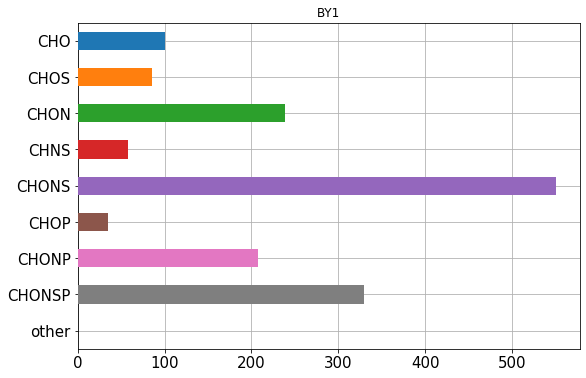

In [13]:
from matplotlib import cm

def plot_composition_series(data, title='',
                            series_order=('CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP', 'other')):
    counts = data['Series'].value_counts().reindex(series_order)
    print(counts)
    colors = cm.get_cmap('tab10', 10).colors
    counts.plot(kind = 'barh', figsize=(9,6), color=colors, fontsize=15, title=title, zorder=3)
    pl.gca().invert_yaxis()
    pl.grid(zorder=0)

plot_composition_series(by1_elems, title='BY1')

# to save the picture to a svg file
#pl.savefig('series_by1.svg')

# Van Krevelen and Kendrick Mass Defect Plots - Dissertation Figures

The following Van Krevelen and Kendrick Mass Defect plots used all the peaks with formulas assigned from the sample 'BY0_000001' (replicate nº 1 from BY4741 Yeast strain data).

For this, no other information from other sample was used and the usual filtering (feature appears in at least two samples in the dataset) wasn't performed.

### Van Krevelen Diagram - Part of Fig. 1.4

In [34]:
# Setting the colours for each Series
colours = sns.color_palette('Set1', 9)
cmap_colours = ListedColormap(colours)

unique_series = ['CHO', 'CHOS', 'CHON', 'CHNS', 'CHONS', 'CHOP', 'CHONP','CHONSP', 'Other']
series_colors = {lbl: c for lbl, c in zip(unique_series,  range(9))}

# Attributing the color for each feature/formula
point_seq =  [series_colors[lbl] for lbl in by1_elems['Series']]

Text(0.5, 1.0, 'Van Krevelen Diagram')

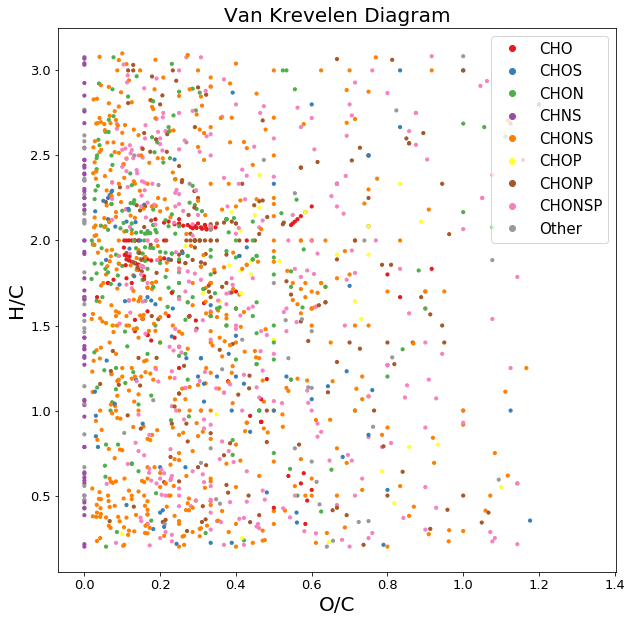

In [35]:
# Plotting the Van Krevelen Diagram and adjusting parameters
def VK_plot(data):
    y = data['H/C']
    x = data['O/C']
    pl.subplots(1,1, figsize=(10,10))
    scatter = pl.scatter(x, y, s=10, c=point_seq, cmap=cmap_colours)
    pl.xlabel('O/C', fontsize=20)
    pl.ylabel('H/C', fontsize=20)
    pl.legend(handles=scatter.legend_elements()[0], labels=unique_series, fontsize=15, loc = 'upper right')


VK_plot(by1_elems)
pl.tick_params(axis='x', which='major', labelsize = 13)
pl.tick_params(axis='y', which='major', labelsize = 13)
pl.title('Van Krevelen Diagram', fontsize=20)
#pl.savefig('VK.svg')

### Kendrick Mass Defect - Part of Fig. 1.4

In [36]:
# Making the bucket label column into floats - numbers (and taking out the " Da" part)
formula_file = by1_elems
formula_file_index = []
for i in range(len(by1_elems)):
    #print(i, (formula_file.index[i]).replace(',','.')[:-3])
    formula_file_index.append(np.float((formula_file.index[i]).replace(',','.')[:-3]))
formula_file.index = formula_file_index
formula_file

,Name,Formula,C,H,N,O,S,P,F,H/C,O/C,Series
307.083818,Glutathione,C10H17N3O6S,10,17,3,6,1,0,0,1.700000,0.600000,CHONS
555.269298,Enkephalin L,C28H37N5O7,28,37,5,7,0,0,0,1.321429,0.250000,CHON
624.087308,NaN,C14H28N10O10S4,14,28,10,10,4,0,0,2.000000,0.714286,CHONS
493.316816,PC_16:1_9Z_0:0_,C24H48NO7P,24,48,1,7,0,1,0,2.000000,0.291667,CHONP
257.102875,Glycerophosphocholine,C8H20NO6P,8,20,1,6,0,1,0,2.500000,0.750000,CHONP
...,...,...,...,...,...,...,...,...,...,...,...,...
1282.453458,NaN,C45H114N6O2S16,45,114,6,2,16,0,0,2.533333,0.044444,CHONS
803.233826,NaN,C21H33N21O12S,21,33,21,12,1,0,0,1.571429,0.571429,CHONS
889.935197,NaN,C17H47O14PS12,17,47,0,14,12,1,0,2.764706,0.823529,Other
551.022512,NaN,C17H9N15O2S3,17,9,15,2,3,0,0,0.529412,0.117647,CHONS


#### Two ways (two KMD plots) to calculate Nominal Mass:

1) Round the Exact Kendrick Mass to the nearest integer 

In [37]:
# Calculating Exact Kendrick Mass
masses = formula_file.index
Kendrick_m = masses * 14 / 14.01565

nominal = []
fraction = []

# Calculating Nominal Kendrick Mass and Kendrick Mass Defect
for i in Kendrick_m:
    s = np.round(i) # Rounding 
    nominal.append(s) # Nominal Kendrick Mass
    fraction.append(s-i) # Kendrick Mass Defect

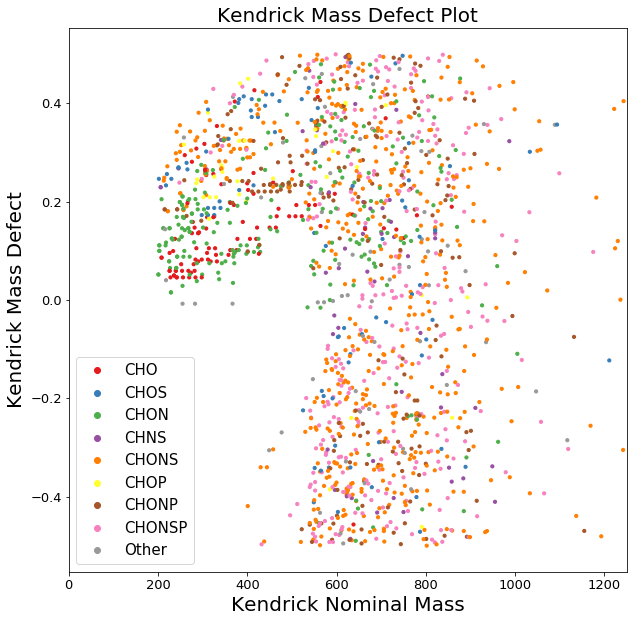

In [38]:
# Plot the Kendrick Mass Defect Plot (KMD Plot) and adjust parameters
pl.subplots(1,1, figsize=(10,10))
scatter = pl.scatter(nominal, fraction, s=10, c=edge_seq, cmap=cmap_colours)
pl.xlabel('Kendrick Nominal Mass', fontsize=20)
pl.ylabel('Kendrick Mass Defect', fontsize=20)
pl.xlim([0,1250])
pl.legend(handles=scatter.legend_elements()[0], labels=unique_series, fontsize=15, loc = 'lower left')
pl.title('Kendrick Mass Defect Plot', fontsize=20)
pl.tick_params(axis='x', which='major', labelsize = 13)
pl.tick_params(axis='y', which='major', labelsize = 13)

2) Round up the Exact Kendrick Mass

In [39]:
nominal = []
fraction = []

# Calculating Nominal Kendrick Mass and Kendrick Mass Defect
for i in Kendrick_m:
    frac, whole = np.modf(i)
    s = whole + 1 # Rounding up
    nominal.append(s) # Nominal Kendrick Mass
    fraction.append(s-i) # Kendrick Mass Defect

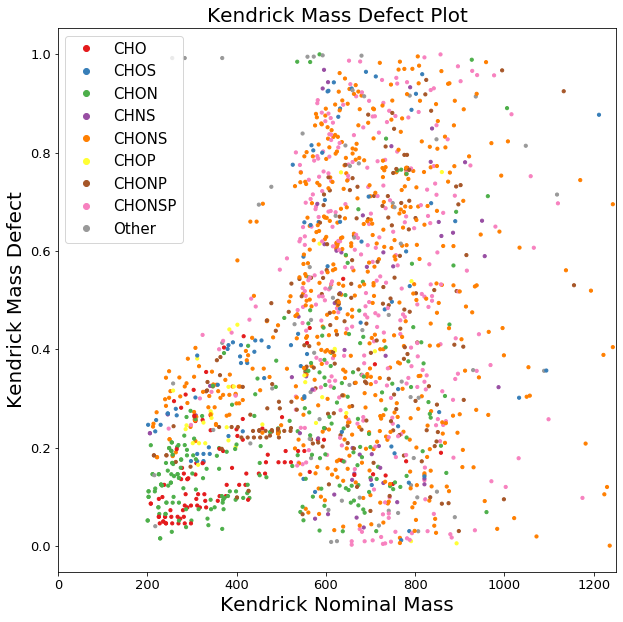

In [40]:
# Plot the Kendrick Mass Defect Plot (KMD Plot) and adjust parameters
pl.subplots(1,1, figsize=(10,10))
scatter = pl.scatter(nominal, fraction, s=10, c=edge_seq, cmap=cmap_colours)
pl.xlabel('Kendrick Nominal Mass', fontsize=20)
pl.ylabel('Kendrick Mass Defect', fontsize=20)
pl.xlim([0,1250])
pl.legend(handles=scatter.legend_elements()[0], labels=unique_series, fontsize=15, loc = 'upper left')
pl.title('Kendrick Mass Defect Plot', fontsize=20)
pl.tick_params(axis='x', which='major', labelsize = 13)
pl.tick_params(axis='y', which='major', labelsize = 13)

# From now on, the rest of the results aren't directly relevant to the dissertation, so the code is less commented and explained

# Obtaining all results for all the samples

Filter the dataset to remove uninformative features (only appear in one sample).

Obtain info for Van Krevelen Diagrams and Series Composition Counts.

In [41]:
# Filter the dataset to remove uninformative features (only appear in one sample)
by1_df_T = remove_feat(by1_df_T, 2/15)

# Store Results
Results = {}
Classes = {}

# Pass every sample through the pipeline and take out info for Van Krevelen diagram (H/C and O/C) and series composition counts
for i in range(15):
    Data = by1_df_T.iloc[:,:3].join(by1_df_T.iloc[:,3+i])
    #print(Data)
    Elems = pipeline(Data)
    Results[Data.columns[-1]] = Elems[['H/C', 'O/C']]
    Classes[Data.columns[-1]] = Elems['Series'].value_counts()

                           m/z                   Name          Formula  \
Bucket label                                                             
307,0838178877 Da    308.09110            Glutathione      C10H17N3O6S   
555,2692975341 Da    556.27657           Enkephalin L       C28H37N5O7   
624,0873082632 Da    625.09457                    NaN   C14H28N10O10S4   
493,3168156897 Da    494.32410        PC_16:1_9Z_0:0_       C24H48NO7P   
257,1028750516 Da    258.11016  Glycerophosphocholine        C8H20NO6P   
...                        ...                    ...              ...   
2029,1188620710 Da  2030.12614                    NaN              NaN   
532,8123880500 Da    533.81966                    NaN      C9H4N5O8PS6   
1069,9969559833 Da  1071.00423                    NaN   C37H18N16O16S4   
1343,9006014319 Da  1344.90788                    NaN   C57H32N6O12S11   
1941,3559575318 Da  1942.36323                    NaN  C39H66N47O39P3S   

                      BY0_000001    B

#### Van Krevelen Diagram Example

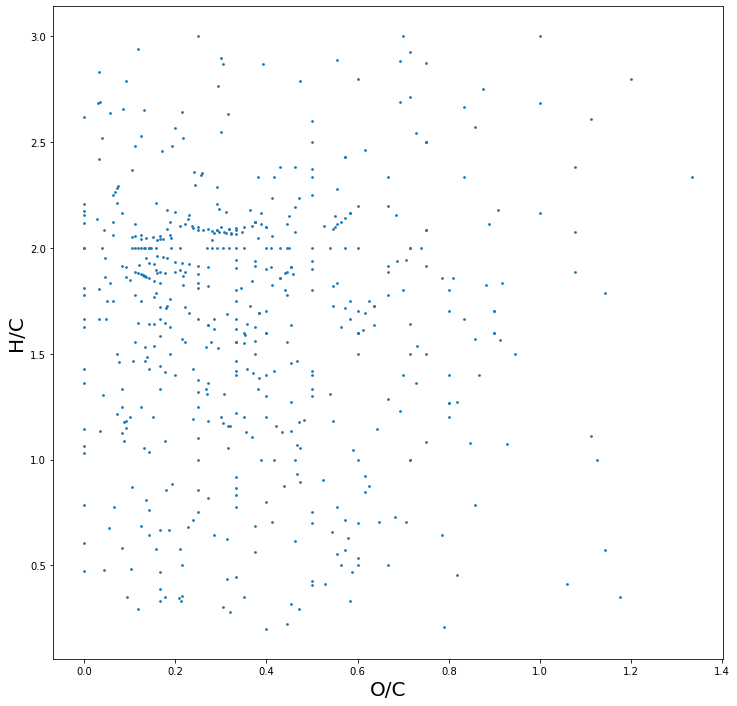

In [42]:
def VK_plot(data):
    y = data['H/C']
    x = data['O/C']
    pl.subplots(1,1, figsize=(12,12))
    pl.scatter(x, y, s=3)
    pl.xlabel('O/C', fontsize=20)
    pl.ylabel('H/C', fontsize=20)

VK_plot(Results['BY0_000001'])
# to save the picture to a svg file

#pl.savefig('VK.svg')

Can't remember what this is for

In [43]:
#BY1 = Results['BY0_000001']
#BY2 = Results['BY0_000002']
#print(BY1)
#BY1 = BY1.loc[~BY1['H/C'].duplicated(keep='first')]
#for i in range(len(BY1)):
#    for j in range(len(BY1)):
#        if i != j:
#            if BY1.iloc[i,0] == BY1.iloc[j,0]:
#                things
#BY1["period"] = BY1["H/C"].astype(str) + BY1["O/C"].astype(str)
#BY1 = BY1.loc[~BY1['period'].duplicated(keep='first')]
#BY2["period"] = BY2["H/C"].astype(str) + BY2["O/C"].astype(str)
#BY2 = BY2.loc[~BY2['period'].duplicated(keep='first')]
#print(len(BY1))

In [44]:
#BY2 = Results['BY0_000002']
#BY2_p = np.unique(BY2[['H/C','O/C']].to_numpy(), axis = 0)

#BY1 = Results['BY0_000001']
#BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
#nrows, ncols = BY1_p.shape
#dtype={'names':['f{}'.format(i) for i in range(ncols)],
#       'formats':ncols * [BY1_p.dtype]}
#a = np.intersect1d(BY1_p.view(dtype), BY2_p.view(dtype))
#b = np.union1d(BY1_p.view(dtype), BY2_p.view(dtype))
#print(BY1_p.view(dtype),BY2_p.view(dtype))
#print(dtype)

## Treatment of the information obtained

3 different datasets will be constructed from these analyses:

1) VK - Van Krevelen - DataFrame with number of times each set of H/C and O/C appears in a sample

2) VK_bin - Van Krevelen - DataFrame with appearances of a pair H/C, O/C in a sample

3) Series_df - Series Composition - Dataset with counts of numbers from each composition series in each sample

In [45]:
labels = ["BY4741","BY4741","BY4741","dGRE3","dGRE3","dGRE3","dENO1","dENO1","dENO1",
          "dGLO1","dGLO1","dGLO1","dGLO2","dGLO2","dGLO2"]

### 1) VK - DataFrame with number of times each set of (H/C, O/C) pair appears in a sample

In [46]:
BY1 = Results['BY0_000001']
BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
nrows, ncols = BY1_p.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [BY1_p.dtype]}

# Store each occurrence of a (H/C,O/C) pair and count how many times a pair is present in a sample
Results_f = {}
jdists = pd.DataFrame(index=Results.keys(), columns = Results.keys())
for i in Results:
    # Clean replicate pairs and count how many each happens
    Results_f[i] = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0, return_counts = True)

# Calculating Jaccard Distance matrix - no longer used  
c = Results_f['BY0_000001'][0].view(dtype)
for i in Results_f:
    c = np.union1d(c, Results_f[i][0].view(dtype))
    for j in Results_f:
        a = np.intersect1d(Results_f[i][0].view(dtype), Results_f[j][0].view(dtype))  
        b = np.union1d(Results_f[i][0].view(dtype), Results_f[j][0].view(dtype))
        jdists.loc[i,j] = 1 - len(a)/len(b)

In [47]:
# Building the VK dataset
VK = pd.DataFrame(np.zeros((len(c),15)),index = c, columns = Results.keys())
#Results_f['BY0_000001'][0] in NewD.index
#NewD.loc[tuple(Results_f['BY0_000001'][0])]
#if tuple(Results_f['BY0_000001'][0]) in NewD.index:
for i in Results_f:
    for j in range(len(Results_f[i][0])):
        VK.loc[[tuple(Results_f[i][0][j])],i] = Results_f[i][1][j] # Number of elements with a certain H/C,O/C pair
mtl.add_labels(VK, labels=labels)
VK

label                                           BY4741                        \
                                            BY0_000001 BY0_000002 BY0_000003   
(0.2, 0.17142857142857143)                         0.0        0.0        0.0   
(0.2, 0.35)                                        0.0        0.0        0.0   
(0.2, 0.4)                                         1.0        1.0        1.0   
(0.2, 0.55)                                        0.0        0.0        1.0   
(0.20689655172413793, 0.034482758620689655)        0.0        0.0        0.0   
...                                                ...        ...        ...   
(3.0833333333333335, 0.2916666666666667)           0.0        0.0        0.0   
(3.0869565217391304, 0.17391304347826086)          0.0        0.0        0.0   
(3.090909090909091, 0.09090909090909091)           0.0        1.0        1.0   
(3.090909090909091, 0.18181818181818182)           0.0        0.0        0.0   
(3.090909090909091, 0.45454545454545453)           0.0        0.0        0.0   

label                                             dGRE3              \
                                            GRE3_000001 GRE3_000002   
(0.2, 0.17142857142857143)                          0.0         0.0   
(0.2, 0.35)                                         0.0         0.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         0.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         1.0   
(3.0869565217391304, 0.17391304347826086)           0.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         0.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                                         dENO1  \
                                            GRE3_000003 ENO1_000001   
(0.2, 0.17142857142857143)                          1.0         0.0   
(0.2, 0.35)                                         0.0         0.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         1.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         1.0   
(3.0869565217391304, 0.17391304347826086)           1.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         0.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                                                \
                                            ENO1_000002 ENO1_000003   
(0.2, 0.17142857142857143)                          0.0         0.0   
(0.2, 0.35)                                         1.0         1.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         1.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         0.0   
(3.0869565217391304, 0.17391304347826086)           0.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         1.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                              dGLO1               \
                                            dGLO1_000001 dGLO1_000002   
(0.2, 0.17142857142857143)               

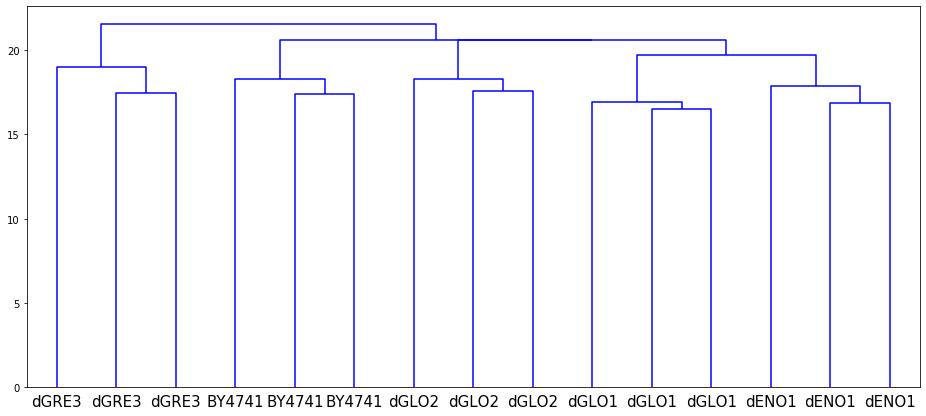

In [48]:
Z_VK = hier.linkage(VK.T, metric = 'euclidean', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_VK, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

### 2) VK_bin - DataFrame with 1s ((H/C, O/C) pair appears in a sample) and 0s (pair does not appear)

In [49]:
BY1 = Results['BY0_000001']
BY1_p = np.unique(BY1[['H/C','O/C']].to_numpy(), axis = 0)
nrows, ncols = BY1_p.shape
dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [BY1_p.dtype]}

# Store each occurrence of a (H/C,O/C) pair in a sample
Results_f = {}
jdists = pd.DataFrame(index=Results.keys(), columns = Results.keys())
for i in Results:
    # Clean replicate pairs
    Results_f[i] = np.unique(Results[i][['H/C','O/C']].to_numpy(), axis = 0)
    
# Calculating Jaccard Distance matrix - no longer used
c = Results_f['BY0_000001'].view(dtype)
for i in Results_f:
    c = np.union1d(c, Results_f[i].view(dtype))
    for j in Results_f:
        a = np.intersect1d(Results_f[i].view(dtype), Results_f[j].view(dtype))  
        b = np.union1d(Results_f[i].view(dtype), Results_f[j].view(dtype))
        jdists.loc[i,j] = 1 - len(a)/len(b)

In [50]:
# Building the VK_bin dataset
VK_bin = pd.DataFrame(np.zeros((len(c),15)),index = c, columns = Results.keys())
#Results_f['BY0_000001'][0] in NewD.index
#NewD.loc[tuple(Results_f['BY0_000001'][0])]
#if tuple(Results_f['BY0_000001'][0]) in NewD.index:
for i in Results_f:
    for j in range(len(Results_f[i])):
        VK_bin.loc[[tuple(Results_f[i][j])],i] = 1 # Only 1

mtl.add_labels(VK_bin, labels=labels)
VK_bin

label                                           BY4741                        \
                                            BY0_000001 BY0_000002 BY0_000003   
(0.2, 0.17142857142857143)                         0.0        0.0        0.0   
(0.2, 0.35)                                        0.0        0.0        0.0   
(0.2, 0.4)                                         1.0        1.0        1.0   
(0.2, 0.55)                                        0.0        0.0        1.0   
(0.20689655172413793, 0.034482758620689655)        0.0        0.0        0.0   
...                                                ...        ...        ...   
(3.0833333333333335, 0.2916666666666667)           0.0        0.0        0.0   
(3.0869565217391304, 0.17391304347826086)          0.0        0.0        0.0   
(3.090909090909091, 0.09090909090909091)           0.0        1.0        1.0   
(3.090909090909091, 0.18181818181818182)           0.0        0.0        0.0   
(3.090909090909091, 0.45454545454545453)           0.0        0.0        0.0   

label                                             dGRE3              \
                                            GRE3_000001 GRE3_000002   
(0.2, 0.17142857142857143)                          0.0         0.0   
(0.2, 0.35)                                         0.0         0.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         0.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         1.0   
(3.0869565217391304, 0.17391304347826086)           0.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         0.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                                         dENO1  \
                                            GRE3_000003 ENO1_000001   
(0.2, 0.17142857142857143)                          1.0         0.0   
(0.2, 0.35)                                         0.0         0.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         1.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         1.0   
(3.0869565217391304, 0.17391304347826086)           1.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         0.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                                                \
                                            ENO1_000002 ENO1_000003   
(0.2, 0.17142857142857143)                          0.0         0.0   
(0.2, 0.35)                                         1.0         1.0   
(0.2, 0.4)                                          0.0         0.0   
(0.2, 0.55)                                         0.0         0.0   
(0.20689655172413793, 0.034482758620689655)         1.0         0.0   
...                                                 ...         ...   
(3.0833333333333335, 0.2916666666666667)            0.0         0.0   
(3.0869565217391304, 0.17391304347826086)           0.0         0.0   
(3.090909090909091, 0.09090909090909091)            0.0         0.0   
(3.090909090909091, 0.18181818181818182)            0.0         1.0   
(3.090909090909091, 0.45454545454545453)            0.0         0.0   

label                                              dGLO1               \
                                            dGLO1_000001 dGLO1_000002   
(0.2, 0.17142857142857143)               

#### Hierarchical Clustering Algorithm (Dendrogram)

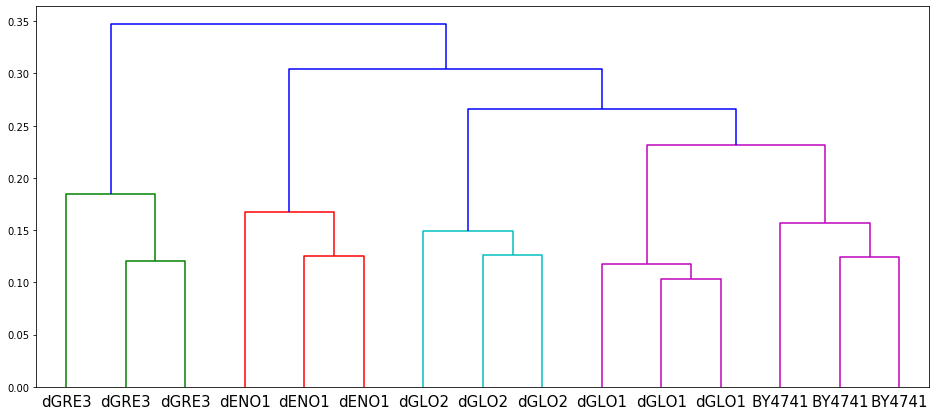

In [51]:
Z_VK_bin = hier.linkage(VK_bin.T, metric = 'yule', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Z_VK_bin, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

### 3) Series_df - Series Composition Counts as information of each sample

In [52]:
Series_df = pd.DataFrame.from_dict(Classes)
mtl.add_labels(Series_df, labels=labels)
Series_df

label      BY4741                             dGRE3                          \
       BY0_000001 BY0_000002 BY0_000003 GRE3_000001 GRE3_000002 GRE3_000003   
CHNS           11         19         16          16          18          11   
CHO            80         90         89          83          91          99   
CHON          124        123        123         115         116         128   
CHONP          67         65         67          58          58          59   
CHONS         143        148        131         110         117         125   
CHONSP         57         63         60          62          65          57   
CHOP           24         29         29          41          37          39   
CHOS           37         42         50          39          52          51   
Other          19         24         28          23          23          23   

label        dENO1                                dGLO1               \
       ENO1_000001 ENO1_000002 ENO1_000003 dGLO1_000001 dGLO1_000002   
CHNS            13          19          20           14           15   
CHO             69          82          82           98           98   
CHON            88         103          94          111          110   
CHONP           60          65          65           61           62   
CHONS          110         123         131          120          124   
CHONSP          54          51          55           50           57   
CHOP            18          20          19           26           28   
CHOS            21          33          37           33           34   
Other           21          20          23           22           18   

label                     dGLO2                          
       dGLO1_000003 GLO2_000001 GLO2_000002 GLO2_000003  
CHNS             11          11          15          12  
CHO              98          84          87          85  
CHON            112          99          97          93  
CHONP            67          73          74          65  
CHONS           120         116         143         141  
CHONSP           48          52          54          63  
CHOP             29          37          35          37  
CHOS             36          33          35          37  
Other            23          22          29          29

#### Hierarchical Clustering Algorithm (Dendrograms)

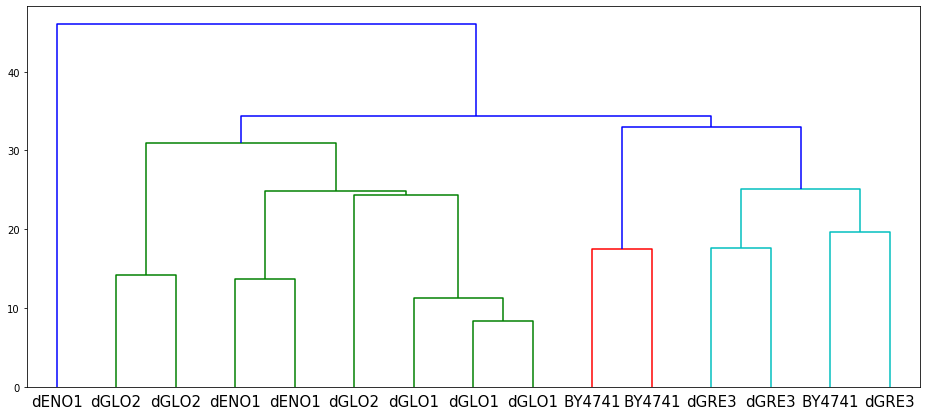

In [54]:
Zseries_neg = hier.linkage(Series_df.T, metric = 'euclidean', method='average')

fig = plt.figure(figsize=(16,7))
dn = hier.dendrogram(Zseries_neg, labels=labels,
                     leaf_font_size=15,
                     above_threshold_color='b')

### K-means clustering

K-means clustering analysis was applied by using the appropriate functions of the scikit-learn as done in the following cells.

Using 3 different metrics explained in the dissertation:

- Discrimination Distance (for K-means clustering)
- Correct Clustering Percentage (for K-means clustering)
- Adjusted Rand Index (calculated by scikit-learn - `adjusted_rand_index`)

Due to the randomness of the K-means clustering analysis (position of initial cluster centers leading to different local minima), this analysis was iterated 150 times and the 10% of analysis that led to a greater minimization of the objective function - sum of squared distances of the samples to the cluster centers - were chosen to calculate the 3 different metrics mentioned. The Median of the different metrics were taken as the final results.

`Kmeans_discrim` function applied here from multianalysis.py file of this repository with explanations of each step to calculate the different metrics.

Correct clustering definition - K-means Cluster contains all and only the samples of a single group (stricter definition than in HCA).

A method similar to the Discrimination Distance and Correct Clustering percentage performed in the HCA was made. Replicates of a variety can be together in a cluster but, if there are more samples in the same cluster, its "discrimination distance" is still zero and the groups isn't correctly clustered. Therefore, this method is harsher than the Discrimination Distance and Correct Clustering Percentage for HCA.  Thus, the Correct Clustering Percentage is expected to be lower in this case

The Discrimination Distance is calculated as the distance between the centroid of the cluster where the samples are and the closest centroid. It is normalized by dividing it by the maximum distance between any 2 centroids of the clusters formed. The mean of the Discrimination Distances of all groups is then a measure of the global Discrimination Distance. 

In [55]:
Data = [VK, VK_bin, Series_df]
colnames = ['VK', 'VK_bin', 'Series']

In [56]:
disc_average = np.zeros((1,3)) # Discrimination Distance
disc_correct = np.zeros((1,3)) # Correct Clustering Percentage
disc_rand = np.zeros((1,3)) # Adjusted Rand Index

for i in range(len(Data)):
    # Applying Kmeans_discrim function 150 times, taking the best 10% and measuring the Discrimination Distance, Correct
    # Clustering percentage and adjusted Rand Index metrics to evaluate the discrimination.
    discrim = ma.Kmeans_discrim(Data[i], method = 'average', iter_num=150, best_fraction=0.1)
    
    # Lists for the results of the best k-means clustering
    average = []
    correct = []
    rand = []
    for j in discrim:
        average.append(discrim[j][0]) # Discrimination Distances
        all_correct = np.array(list(discrim[j][1].values()))
        correct.append(len(all_correct[all_correct>0])) # Correct Clustering Percentages
        rand.append(discrim[j][2]) # Adjusted Rand Index
    
    # Putting results into the arrays - median of the best k-means clustering
    disc_average[0,i] = np.median(average) 
    disc_correct[0,i] = np.median(correct)
    disc_rand[0,i] = np.median(rand)

# Transforming into DataFrame
disc_average = pd.DataFrame(disc_average, index = ['Discrimination Distance'], columns = colnames)
disc_correct = pd.DataFrame(disc_correct * 100 / 5, index = ['% correct groupings'], columns = colnames) # Transforming into %s
disc_rand = pd.DataFrame(disc_rand, index = ['Rand Index'], columns = colnames)

##### K-means Clustering Analysis Resultss

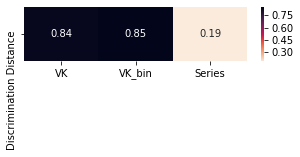

In [57]:
# Discrimination Distance
f, ax = plt.subplots(figsize=(5, 1))
hm = sns.heatmap(disc_average, annot=True, ax=ax, cmap = sns.cm.rocket_r)
plt.show()

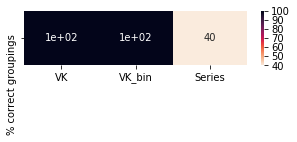

In [58]:
# Correct Clustering Percentage
f, ax = plt.subplots(figsize=(5, 1))
hm = sns.heatmap(disc_correct, annot=True, ax=ax, cmap = sns.cm.rocket_r)

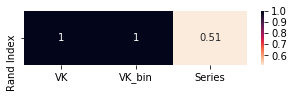

In [59]:
# Adjusted Rand Index
f, ax = plt.subplots(figsize=(5, 1))
hm = sns.heatmap(disc_rand, annot=True, ax=ax, cmap = sns.cm.rocket_r)

## Supervised Statistical Analysis


In [60]:
datasets = {'VK': VK, 'VK_bin': VK_bin, 'Series': Series_df}

### Random Forest

#### Test number of trees needed for predictive accuracy convergence

In [61]:
#Vector with values for the parameter n_estimators
values = {}
values['n_estimators'] = range(10,200,10)

In [62]:
from sklearn.model_selection import GridSearchCV
import sklearn.ensemble as skensemble
rf = skensemble.RandomForestClassifier(n_estimators = 200)
clf = GridSearchCV(rf, values, cv =3)

In [63]:
param = []
test_score = []

for name, dataset in datasets.items():
    print('Fitting', name, '...', end=' ')
    clf.fit(dataset.T, labels)
    param.append(clf.cv_results_['param_n_estimators'])
    test_score.append(clf.cv_results_['mean_test_score'])
    print('Done!')

Fitting VK ... Done!
Fitting VK_bin ... Done!
Fitting Series ... Done!


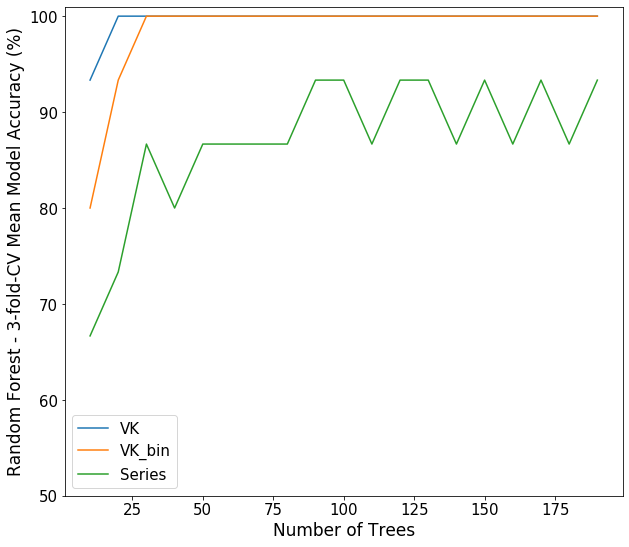

In [64]:
# Plotting the results and adjusting parameters of the plot
f, ax = plt.subplots(figsize=(10,9))

for i in range(len(param)):
    plt.plot(param[i], test_score[i]*100)

plt.ylabel('Random Forest - 3-fold-CV Mean Model Accuracy (%)', fontsize = 17)
plt.xlabel('Number of Trees', fontsize = 17)
ax.legend(('VK', 'VK_bin', 'Series'), fontsize=15)
plt.ylim(50,101)
ax.tick_params(axis='both', which='major', labelsize=15)

### Random Forest Application

In [65]:
# Preparations of dicts:
Scores = {} # Stores Predictive Accuracy
Scores_std = {} # Stores Predictive Accuracy's Standard Deviation
Imp_feat = {} # Stores ordered list of most to least important feature to build the model

In [66]:
# Application of the Random Forests
for name, data in datasets.items():
    print(f'Fitting random forest for {name} ...', end='')
    rf, imp_features = ma.simple_RF(data) #, iter_num = 100)
    Scores[name] = rf
    Scores_std[name] = np.std(rf)
    Imp_feat[name] = imp_features
    print(f'done')   

Fitting random forest for VK ...done
Fitting random forest for VK_bin ...done
Fitting random forest for Series ...done


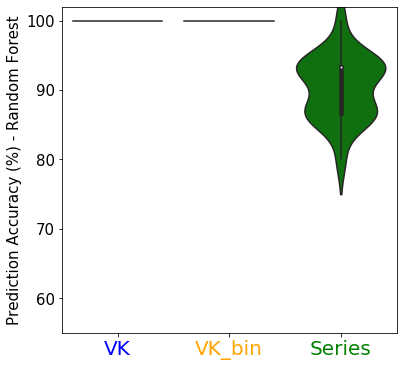

In [67]:
# Violin plot of the distribution of the predictive accuracy (in %) across 200 iterations of randomly sampled folds for each 
# differently-treated dataset and adjustments to the parameters of the plot.
f, ax = plt.subplots(figsize=(6,6))

# Select only data from the Negative Grapevine Dataset
data = pd.DataFrame.from_dict(Scores) * 100

data.columns = ['VK', 'VK_bin', 'Series']
colors = ['blue','orange','green']
sns.violinplot( data = data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - Random Forest', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize = 20)
ax.tick_params(axis='y', which='major', labelsize = 15)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

In [68]:
# Average prediction accuracy of the models built for each of the
# differently-treated datasets estimated by stratified 3-fold cross validation
Scores_A = {}
for i in Scores:
    Scores_A[i] = np.mean(Scores[i])
Scores_A

{'VK': 1.0, 'VK_bin': 1.0, 'Series': 0.9033333333333333}

### Characteristics of the features considered as important in the differently-treated datasets (Negative and Positive)

We take the 2% most important features in each case and calculate the median number of samples those features appear (samples_m), the median number of different groups/varieties those features appear in (groups_n) and the ratio between these two measures (ratio_m, has a maximum of 3). 

A swarmplot is also built to see the distributions of the number of samples each important feature in each method appears to see their overall distribution.

We also see how many times the importance of the most important feature is greater than the average importance of a feature in each case ('magni') as well as the % of the model explained (that use) the 2% of the most important features ('explained').

For 'Series', just observe the feature importance

In [71]:
Imp_feat['Series']

[(6, 0.15405021000938526, 'CHOP'),
 (2, 0.14742753096455183, 'CHON'),
 (1, 0.13021700114751833, 'CHO'),
 (3, 0.12055429845309695, 'CHONP'),
 (7, 0.1073447795718157, 'CHOS'),
 (4, 0.09546494535200531, 'CHONS'),
 (5, 0.09066685957561739, 'CHONSP'),
 (8, 0.08223136415584391, 'Other'),
 (0, 0.07204301077016534, 'CHNS')]

In [72]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature,
# calculating % explained by these features (explained) and identification of important features (in negative and positive GD)
ev = []
magni = []
explained = []

for name in Imp_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('VK'):
        Spectra = VK
    elif name.endswith('bin'):
        Spectra = VK_bin
    else:
        continue
        #Spectra = Series_df

    # Important Features
    imp_features = Imp_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    imp_feat_id_temp = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni.append(imp_features[0][1]/(1/len(Spectra))) # Calculate, store how many times feature is more important than average
    
    a = 0 # Count the % explained - add for each feature
    for i in range(number): # Iterate for only the number of features considered as important
        a = a + imp_features[i][1]*100 
        
        ngroups = {}
        line = (Spectra.loc[[imp_features[i][2]],:] != 0) #.notnull() # Identify feature in Spectra
        #line = Spectra.loc[[imp_features[i][2]],:].notnull()
        nsamples.append(int(line.sum(axis=1)))
        #nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line.columns)):
            if line.iloc[0,n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
        
        # Store identification of feature
        imp_feat_id_temp.append(imp_features[i][2])
    
    explained.append(a) # Store % explained
    
    # Organizing info in a dataframe and store it in 'ev'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev.append(df)

In [75]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'e'
for i in range(len(ev)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev[i].iloc[:,0]))
    groups_m.append(np.median(ev[i].iloc[:,1]))
    ratio_m.append(np.median(ev[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = ['VK', 'VK_bin'])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m

df

,Sample Nº,Group nº,Ratio
VK,3.0,1.0,3.0
VK_bin,3.0,1.0,3.0


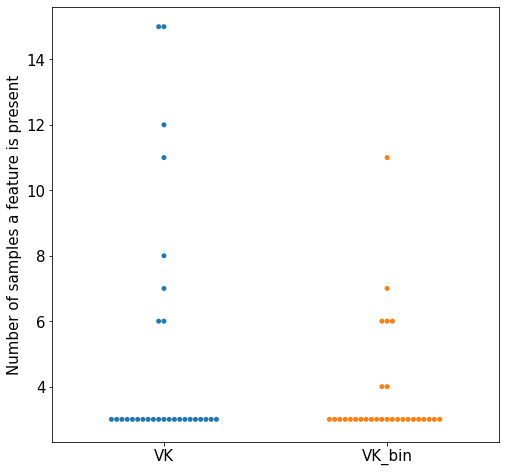

In [76]:
f, ax = plt.subplots(figsize=(8,8))
data = [ev[i]['nsamples'] for i in range(len(ev))]
sns.swarmplot(data=data, size = 5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set(xticklabels = ['VK','VK_bin'])
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

In [77]:
print('Magnitude of most important feature:', magni)
print('% of model explained by the 2% most important features', explained)

Magnitude of most important feature: [5.718278120819244, 5.12845735796798]
% of model explained by the 2% most important features [8.326297253126127, 8.351868153412248]


### Permutation Tests - Random Forests

Permutation tests is based on shuffling the labels of the different samples, shuflling the groups where they belong with the intent to see if the classifier tested, whether it is Random Forest or PLS-DA found a significant class structure in the data - assess the significance of the predictive accuracy results. 

For that a random 3-fold cross-validation is performed on the original dataset (to serve as a comparation point) and 1000 permutations of datasets with labels randomly shuffled around with the model being evaluated by how good the predictions the model does of the test data is. 

The empirical p-value is given by (the number of times the permutation accuracy was bigger than the random 3-fold cross-validation made with the original dataset + 1) / (number of permutations + 1) (source: Ojala2010 - error should be the opposite of the accuracy).

Histograms with the prediction accuracy of the different permutations were plotted and compared to the accuracy got with the original dataset.

Use of `permutation_RF` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [78]:
CV = {}
PMs = {}
pvalue = {}

In [79]:
permuta = ma.permutation_RF(VK, iter_num = 100, n_fold = 3)
CV['VK'] = permuta[0]
PMs['VK'] = permuta[1]
pvalue['VK'] = permuta[2]

In [80]:
all_data = (VK, VK_bin, Series_df)
names = ('VK', 'VK_bin', 'Series')

# Application of permutations tests (with 1000 iterations)
for name, data in zip(names, all_data):
    print(f'Permutation test (Random Forest) for {name} ...')
    permuta = ma.permutation_RF(data, iter_num=100, n_fold=3)
    CV[name] = permuta[0]
    PMs[name] = permuta[1]
    pvalue[name] = permuta[2]
    print('Done!')

Permutation test (Random Forest) for VK ...
Done!
Permutation test (Random Forest) for VK_bin ...
Done!
Permutation test (Random Forest) for Series ...
Done!


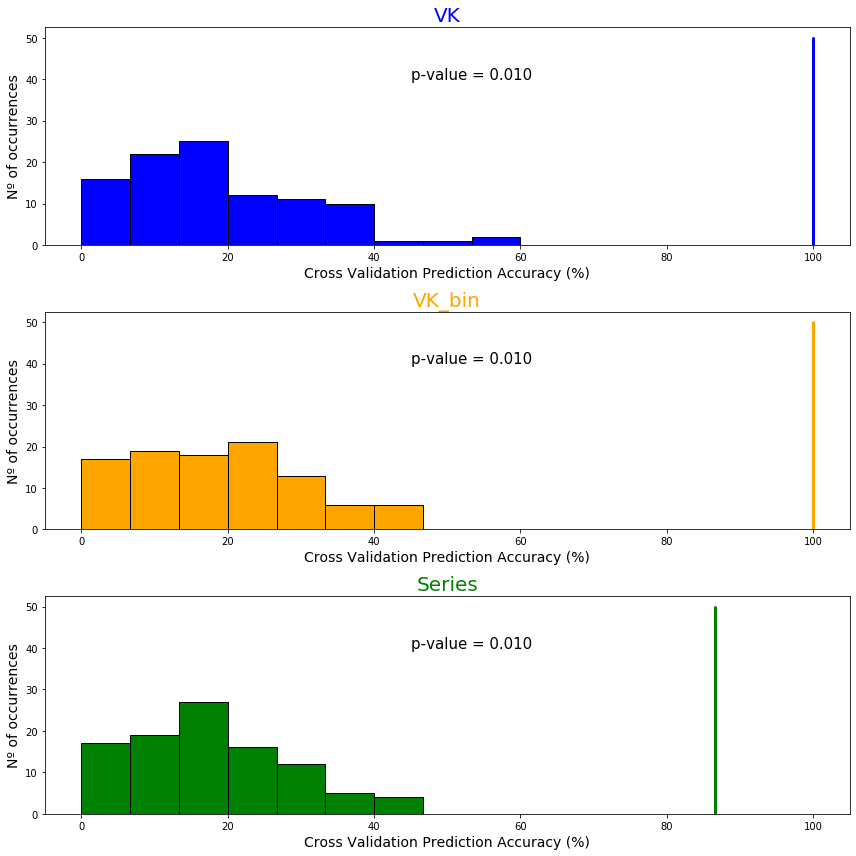

In [81]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(3, 1, figsize = (12,12))
colors = ['blue', 'orange', 'green']
Names = ['VK', 'VK_bin', 'Series']
quadrant = [axes[0], axes[1], axes[2]]
ylim = [0,50]
n_labels = len(VK.cdl.labels)

# Application of permutations tests (with 1000 iterations)
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs[name])*100, n_labels, range=(0, 100.01), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV[name]* 100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences', fontsize=12)
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(45,40, 'p-value = %.3f' % pvalue[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()

## PLS-DA - Classifiers

Creating the target vectors matrix where each different group is made into a column and 1 represents the sample belongs to that group (0 means it doesn't belong) with one-hot encoding.

PLS-DA models were built using the PLSRegression module of scikit-learn while imposing a decision rule where the group corresponding to the maximum value in the predicted regression vector (one value for each group) obtained for a test sample (ypred) is chosen. 

In [82]:
matrix = pd.get_dummies(VK.cdl.labels)
matrix = matrix[["BY4741","dGRE3","dENO1","dGLO1","dGLO2"]]

#### Optimization - Search for the best number of components to use 

In [83]:
%%capture --no-stdout

# Store Results
PLS_optim = {}

# Build and extract metrics from models build with different number of components by using the optim_PLS function.
for name, data in datasets.items():
    print(f'Optimizing PLS-DA for {name} ...', end='')
    if name == 'Series':
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 7)
    else:
        CVs, CVr2s, MSEs = ma.optim_PLS(data, max_comp = 30)
    PLS_optim[name] = CVs
    print(f'done')    

Optimizing PLS-DA for VK ...done
Optimizing PLS-DA for VK_bin ...done
Optimizing PLS-DA for Series ...done


Performance based on number of components


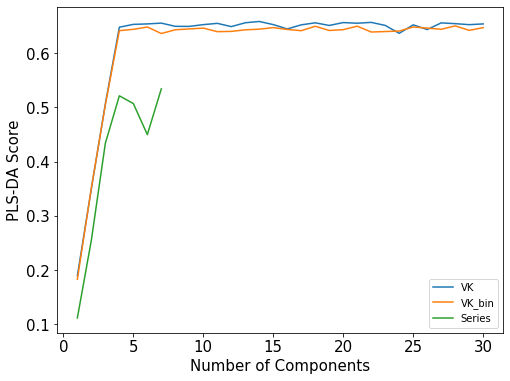

In [84]:
f, ax = plt.subplots(figsize=(8,6))
plt.plot(range(1,31), PLS_optim['VK'])
plt.plot(range(1,31), PLS_optim['VK_bin'])
plt.plot(range(1,8), PLS_optim['Series'])
plt.ylabel('PLS-DA Score', fontsize = 15)
plt.xlabel('Number of Components', fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(('VK','VK_bin','Series'))
print('Performance based on number of components')

### Application of PLS-DA - Part of Fig. 3.5 and Suppl. Fig. 6.6

We can now transform the PLS algorithm (PLS2 algorithm used) to give classification of samples instead of regression using a decision rule to interpret the y_pred result given for each test sample and decide what group it belongs to. In this case a simple rule of the group with the highest number (closer to 1) is decided to be the group to which said sample belongs to - naive MAX rule. Models were evaluated according to their predictive accuracy estimated by 3-fold cross-validation.

Use of function `model_PLSDA` of multianalysis.py file. See this file to see the application of this function more in-depth (used `PLSRegression` from scikit-learn).

3 different feature importance metrics (feat_type):

- VIP (Variable Importance/Influence in Projection)
- Coef. (regression coefficients - sum)
- Weights (Sum of the X-weights for each feature)

In [85]:
# Dictionaries to store results
PLS_accu = {}
PLS_score = {}
PLS_feat = {}

In [86]:
%%capture --no-stdout
for name, data in datasets.items():
    print(f'Fitting PLS-DA for {name} ...', end='')
    accu, score, u, imp_features = ma.model_PLSDA(data, n_comp = 4, iter_num = 100)#, feat_type = 'VIP')
    PLS_accu[name] = accu
    PLS_score[name] = score
    PLS_feat[name] = imp_features
    print(f'done')    

Fitting PLS-DA for VK ...done
Fitting PLS-DA for VK_bin ...done
Fitting PLS-DA for Series ...done


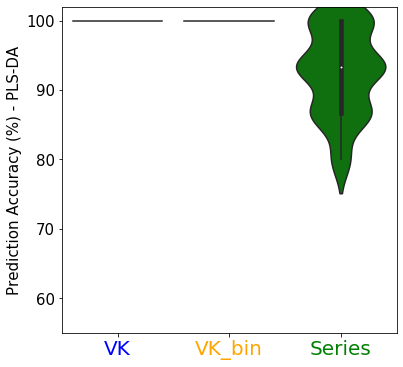

In [87]:
# Plot the distribution of prediction accuracy
# Adjust Parameters
f, ax = plt.subplots(figsize=(6,6))
colors = ['blue','orange','green']
data=pd.DataFrame.from_dict(PLS_accu) * 100
data.columns = ['VK', 'VK_bin', 'Series']
sns.violinplot(data=data, palette = colors, alpha = 0.5)
plt.ylabel('Prediction Accuracy (%) - PLS-DA', fontsize = 15)
plt.ylim([55,102])
ax.tick_params(axis='x', which='major', labelsize= 20)
ax.tick_params(axis='y', which='major', labelsize= 15)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

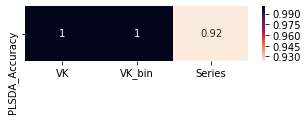

In [88]:
# Average Accuracy across the iterations for each differently-treated dataset
Accuracy = {}
Accuracy_std = {}
for name in PLS_score.keys():
    Accuracy[name] = np.mean(PLS_accu[name])
    Accuracy_std[name] = np.std(PLS_accu[name])
    
Accuracy_H = pd.DataFrame(list(Accuracy.values()), index = Accuracy.keys()).T

f, ax = plt.subplots(figsize=(5, 1))
hm = sns.heatmap(Accuracy_H, annot=True, ax=ax, cmap = sns.cm.rocket_r, yticklabels = ['PLSDA_Accuracy'])
plt.show()

### Characteristics of the most important features

Series (not select important features - just 10)

In [89]:
PLS_feat['Series']

[(6, 0.09579700702068049, 'CHOP'),
 (1, 0.08789528440903997, 'CHO'),
 (2, 0.05935906373515951, 'CHON'),
 (4, 0.05892197833929561, 'CHONS'),
 (7, 0.048384532227588185, 'CHOS'),
 (5, 0.04293916897584419, 'CHONSP'),
 (3, 0.03923042631954134, 'CHONP'),
 (0, 0.03276757458922375, 'CHNS'),
 (8, 0.025682019435592077, 'Other')]

In [90]:
# Getting the number of samples, groups, ratios for each important feature, magnitude for most important feature
ev_PLS = []
magni_PLS = []

for name in PLS_feat:
    # Choose the respective original spectra for each differently treated dataset
    if name.endswith('VK'):
        Spectra = VK
    elif name.endswith('bin'):
        Spectra = VK_bin
    else:
        continue
        #Spectra = Series_df
    
    # Important Features
    imp_features = PLS_feat[name]
    
    ratio = []
    nsamples = []
    n_groups = []
    
    # Top 2% (rounded)
    number = round(0.02*len(Spectra))
    magni_PLS.append(imp_features[0][1]/(1/len(Spectra))) # Calculate how many times feature is more important than average
    
    for i in range(number): # Iterate for only the number of features considered as important
        
        ngroups = {}
        line = (Spectra.loc[[PLS_feat[name][i][2]],:] != 0) #.notnull() # Identify feature in Spectra
        #line = Spectra.loc[[imp_features[i][2]],:].notnull()
        nsamples.append(int(line.sum(axis=1)))
        #nsamples.append(line.sum()) # Count how many samples the feature appears in
        
        # Count how many groups the feature appears in
        for n in range(len(line.columns)):
            if line.iloc[0,n] == True:
                ngroups[Spectra.cdl.labels[n]] = 1
        n_groups.append(sum(list((ngroups.values()))))
        
        # Calculate the ratio of number of samples to number of groups the feature appears in
        ratio.append(nsamples[-1]/n_groups[-1])
    
    # Organizing info in a dataframe and store it in 'ev_PLS'
    df = pd.DataFrame(columns = ['nsamples', 'n_groups', 'ratio'])
    df['nsamples'] = nsamples
    df['n_groups'] = n_groups
    df['ratio']  = ratio
    ev_PLS.append(df)

    #print(ev[4])

In [91]:
# Calculating medians of number of samples, groups and ratios and storing information in a DataFrame
ratio_m = []
samples_m = []
groups_m = []

# For each DataFrame in 'ev_PLS'
for i in range(len(ev_PLS)):
    # Calculate and store the median for the sample number, group number and ratio
    samples_m.append(np.median(ev_PLS[i].iloc[:,0]))
    groups_m.append(np.median(ev_PLS[i].iloc[:,1]))
    ratio_m.append(np.median(ev_PLS[i].iloc[:,2]))
    
# Organize information in a DataFrame
df = pd.DataFrame(columns = ['Sample Nº', 'Group nº', 'Ratio'], index = ['VK', 'VK_bin'])
df['Sample Nº'] = samples_m
df['Group nº'] = groups_m
df['Ratio'] = ratio_m

In [92]:
df

,Sample Nº,Group nº,Ratio
VK,7.0,3.0,2.5
VK_bin,6.0,2.0,3.0


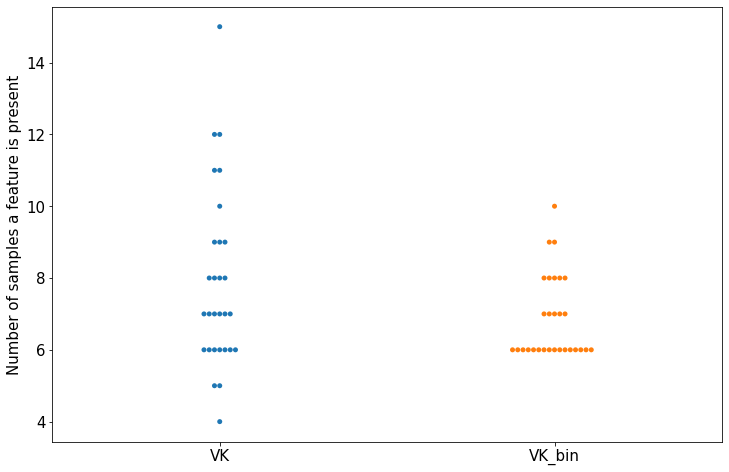

In [93]:
f, ax = plt.subplots(figsize=(12,8))
data = [ev_PLS[i]['nsamples'] for i in range(len(ev_PLS))]
sns.swarmplot(data=data, size = 5)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set(xticklabels = ['VK','VK_bin'])
plt.ylabel('Number of samples a feature is present', fontsize = 15)
plt.show()

### Permutation Tests - PLS-DA

Same explanation as presented for Permutation Tests - Random Forests

Use of `permutation_PLSDA` function from multianalysis.py. See details about the application of this function in the multianalysis.py file.

In [94]:
# Store results
CV_PLS = {}
PMs_PLS = {}
pvalue_PLS = {}

In [95]:
for name, data in zip(names, all_data):
    print(f'permutation test (PLS-DA) for {name} ...')
    permuta = ma.permutation_PLSDA(data, n_comp=4, iter_num=1000)
    CV_PLS[name] = permuta[0]
    PMs_PLS[name] = permuta[1]
    pvalue_PLS[name] = permuta[2]
    print('Done!')

permutation test (PLS-DA) for VK ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for VK_bin ...


C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
C:\Users\francisco\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:79: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


Done!
permutation test (PLS-DA) for Series ...
Done!


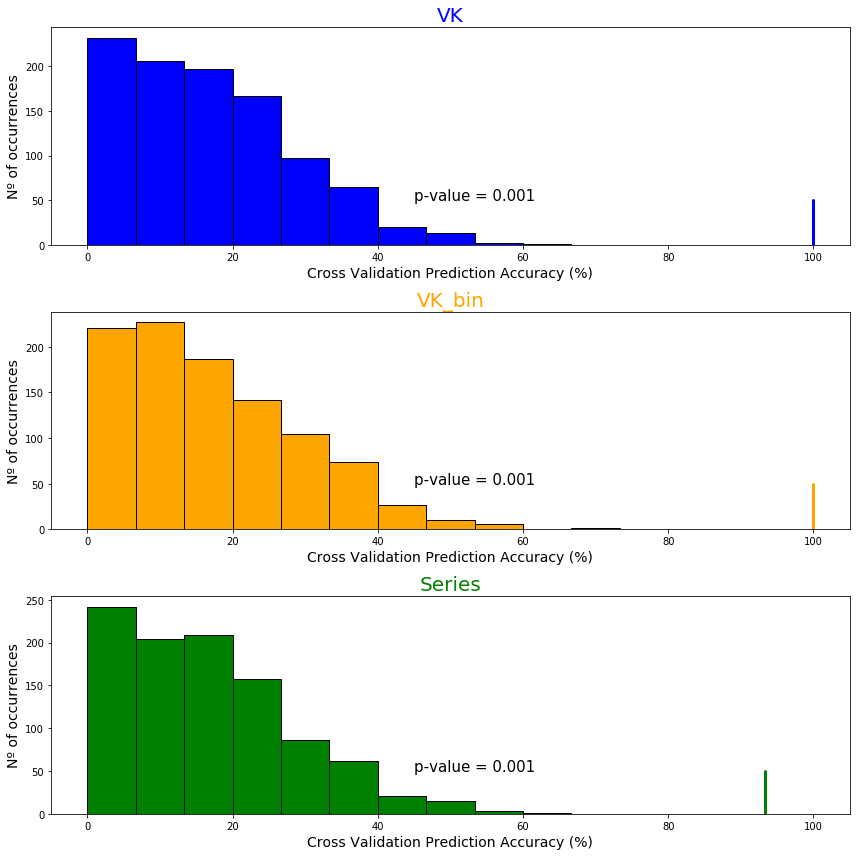

In [96]:
# Plot the Permutations test results - Histogram of predictive accuracies of permutated labels and comparison to reference
# predictive accuracy
f, axes = plt.subplots(3, 1, figsize = (12,12))
colors = ['blue', 'orange', 'green']
Names = ['VK', 'VK_bin', 'Series']
quadrant = [axes[0], axes[1], axes[2]]
ylim = [0,50]
n_labels = len(VK.cdl.labels)

# Setting the parameters of the figure
for q, name, color in zip(quadrant, Names, colors):
    q.hist(np.array(PMs_PLS[name])*100, n_labels, range=(0, 100.001), label=name + ' Permutations',
             edgecolor='black', color=color) #, alpha = 0.3)
    
    q.plot(2 * [CV_PLS[name]*100], ylim, '-', linewidth=3, color=color, #alpha = 0.5,
             label=name + ' (pvalue %.5f)' % pvalue_PLS[name], solid_capstyle='round')
    #q.set(xlabel='Cross Validation Prediction Accuracy (%)', ylabel='Nº of occurrences')
    q.set_xlabel('Cross Validation Prediction Accuracy (%)', fontsize=14)
    q.set_ylabel('Nº of occurrences', fontsize=14)
    q.text(45,50, 'p-value = %.3f' % pvalue_PLS[name], fontsize = 15)
    q.set_title(name, size = 20, color = color)

plt.tight_layout()